This notebook documents how to query traffic-aware travel times, using the Mapbox Directions API.  
Before running this you should have a cleaned graph object ready to use.  
TODO: Clean this script, and modularize this processs

### Load GOSTnets library and graph

In [1]:
import os, sys, math, time

# GostNetsPath = r'C:\Users\gost_\Desktop\lima\GOSTNets\GOSTNets'
# GostNetsPath = '/Users/andreschamorro/Repos/GOST_PublicGoods/GOSTNets/GOSTNets'

print("Current directory is %s" % os.getcwd())
GostNetsPath = os.path.expanduser("~/Repos/GOST_PublicGoods/GOSTNets/GOSTNets")
sys.path.insert(0, GostNetsPath)
# print(sys.path)

import GOSTnet as gn
# import OSMParser
import LoadOSM as losm

import networkx as nx
import geopandas as gpd
import numpy as np
import osmnx as ox
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import inspect

Current directory is /Users/andreschamorro/Scripts_Mac/Dhaka


In [2]:
os.chdir(os.path.expanduser("~/Data/Dhaka"))

In [3]:
!ls

Mapbox-Traffic.qgs          male_jobs.dbf
dhaka_clean_small.pickle    male_jobs.prj
dhaka_clean_small_edges.csv male_jobs.qpj
dhaka_clean_small_nodes.csv male_jobs.shp
male_jobs.cpg               male_jobs.shx
male_jobs.csv


In [4]:
G = nx.read_gpickle("dhaka_clean_small.pickle")

In [5]:
print(nx.info(G))

Name: 
Type: MultiDiGraph
Number of nodes: 25471
Number of edges: 68647
Average in degree:   2.6951
Average out degree:   2.6951


In [6]:
gn.example_edge(G,1)

(0, 4244, {'Wkt': 'LINESTRING (90.35207870000001 23.7962001, 90.35269099999999 23.7962498)', 'id': 22077, 'infra_type': 'residential', 'osm_id': '466261136', 'key': 'edge_22077', 'length': 0.06264263620190162, 'Type': 'legitimate'})


In [7]:
edges = gn.edge_gdf_from_graph(G)

In [9]:
edges.infra_type.value_counts()

residential       48485
unclassified       5833
tertiary           4014
secondary          3404
service            3063
primary            2784
trunk               506
track               238
primary_link        136
trunk_link           92
secondary_link       80
tertiary_link        12
Name: infra_type, dtype: int64

### Filter roads of interest

Check the Mapbox telemetry documentation (https://www.mapbox.com/telemetry/) to get a sense of the quality of traffic data for your area of interest, and which roads have data.

If you wanted to inspect this map in QGIS/ArcMap you can make a new Mapbox Style using the navigation template (which contains traffic data), and then load it as a WMTS service. For example, this is is the coverage for Dhaka. 

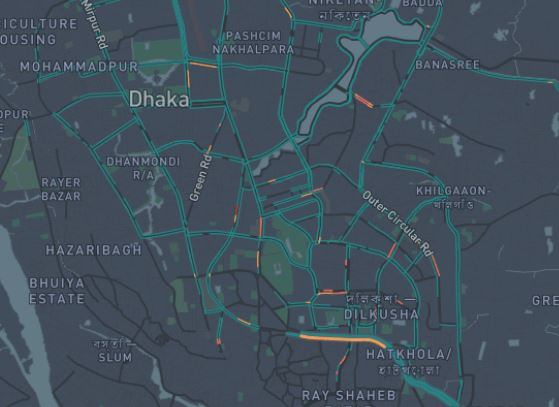

In this case we select only trunk, primary, secondary, and tertiray roads.

In [10]:
accepted_road_types = ['tertiary','secondary','primary','trunk','primary_link','trunk_link','tertiary_link','secondary_link']

In [11]:
edges = edges[edges.infra_type.isin(accepted_road_types)]

In [79]:
len(set(edges.id))

5515

In [13]:
len(edges)

11028

Note: Edges don't have a unique id.

In [15]:
for idx, row in edges.iterrows():
    edges.loc[idx, 'start_x'] = G.nodes[row.stnode]['x']
    edges.loc[idx, 'start_y'] = G.nodes[row.stnode]['y']
    edges.loc[idx, 'end_x'] = G.nodes[row.endnode]['x']
    edges.loc[idx, 'end_y'] = G.nodes[row.endnode]['y']    

In [16]:
edges.head()

,stnode,endnode,key,id,Type,infra_type,Wkt,osm_id,length,geometry,start_x,start_y,end_x,end_y
16,8,13909,edge_9633,9633,legitimate,tertiary,"LINESTRING (90.40712190000001 23.7182804, 90.4...",239878634,0.093185,"LINESTRING (90.40712190000001 23.7182804, 90.4...",90.407122,23.718280,90.406941,23.717464
17,8,17612,edge_9660,9660,legitimate,tertiary,"LINESTRING (90.4060934 23.7203881, 90.40644469...",240115343,0.261165,"LINESTRING (90.40712190000001 23.7182804, 90.4...",90.407122,23.718280,90.406093,23.720388
26,11,3526,edge_11084,11084,legitimate,tertiary,"LINESTRING (90.38636990000001 23.8845511, 90.3...",306064948,0.045416,"LINESTRING (90.38636990000001 23.8845511, 90.3...",90.386370,23.884551,90.386335,23.884142
27,11,8990,edge_11083,11083,legitimate,tertiary,"LINESTRING (90.38646009999999 23.885246, 90.38...",306064948,0.077539,"LINESTRING (90.38636990000001 23.8845511, 90.3...",90.386370,23.884551,90.386460,23.885246
47,18,2317,edge_4630,4630,legitimate,tertiary,"LINESTRING (90.36177929999999 23.7450579, 90.3...",33798206,0.035748,"LINESTRING (90.36177929999999 23.7450579, 90.3...",90.361779,23.745058,90.362114,23.745151


### Build and make requests

In [18]:
## library Imports
import json, sys, os, time, argparse, logging
import shapely

import pandas as pd
import numpy as np
try:
    import urllib.request as url   # python 3
except:
    import urllib2 as url  # python 2

In [140]:
mb_token = '--ENTER YOUR MAPBOX TOKEN HERE--'
base_url = 'https://api.mapbox.com/directions/v5/mapbox/driving-traffic/'
end_url = f'?&{mb_token}'
numcalls = 0
loop_count = 1
new_df = pd.DataFrame(columns=['start_node', 'end_node', 'duration'], index=edges.index)

In [141]:
start = time.time()
for idx, row in edges.iterrows():
    
    # build request
    start_x = row['start_x']
    start_y = row['start_y']
    end_x = row['end_x']
    end_y = row['end_y']
    coordinates = str(start_x)+','+str(start_y)+';'+str(end_x)+','+str(end_y)
    request = base_url+coordinates+end_url
    r = url.urlopen(request)
    data = json.loads(r.read().decode('utf-8'))['routes'][0]['duration']

    # assign response duration value to new df
    new_df.loc[idx,'start_node'] = row['stnode']
    new_df.loc[idx,'end_node'] = row['endnode']
    new_df.loc[idx,'duration'] = data
    
    numcalls += 1
    if numcalls == 299:
        
        elapsed_seconds = (time.time() - start)%60
        print(f"Did {numcalls+1} calls in {elapsed_seconds:.2f} seconds, now wait {60-elapsed_seconds:.2f}, {(300*loop_count)/len(edges):.2%} complete")
        new_df.to_csv('new_edges_temp.csv')
        time.sleep(60-elapsed_seconds)

        # reset count
        numcalls = 0
        start = time.time()
        loop_count += 1

Did 300 calls in 42.64 seconds, now wait 17.36, 2.72% complete
Did 300 calls in 39.71 seconds, now wait 20.29, 5.44% complete
Did 300 calls in 38.38 seconds, now wait 21.62, 8.16% complete
Did 300 calls in 39.43 seconds, now wait 20.57, 10.88% complete
Did 300 calls in 42.74 seconds, now wait 17.26, 13.60% complete
Did 300 calls in 41.66 seconds, now wait 18.34, 16.32% complete
Did 300 calls in 41.19 seconds, now wait 18.81, 19.04% complete
Did 300 calls in 41.91 seconds, now wait 18.09, 21.76% complete
Did 300 calls in 40.50 seconds, now wait 19.50, 24.48% complete
Did 300 calls in 41.89 seconds, now wait 18.11, 27.20% complete
Did 300 calls in 43.01 seconds, now wait 16.99, 29.92% complete
Did 300 calls in 33.78 seconds, now wait 26.22, 32.64% complete
Did 300 calls in 42.15 seconds, now wait 17.85, 35.36% complete
Did 300 calls in 42.52 seconds, now wait 17.48, 38.08% complete
Did 300 calls in 44.08 seconds, now wait 15.92, 40.81% complete
Did 300 calls in 41.51 seconds, now wait 18

IndexError: list index out of range

re start process, catching errors where duration wasn't available

In [157]:
edges_failed = edges.loc[new_df[new_df.duration.isna()].index]

In [171]:
start = time.time()
for idx, row in edges_failed.iterrows():
    
    # build request
    start_x = row['start_x']
    start_y = row['start_y']
    end_x = row['end_x']
    end_y = row['end_y']
    coordinates = str(start_x)+','+str(start_y)+';'+str(end_x)+','+str(end_y)
    request = base_url+coordinates+end_url
    r = url.urlopen(request)
    try:
        data = json.loads(r.read().decode('utf-8'))['routes'][0]['duration']
    except:
        data = np.nan
        print(f'failed at idx {idx}')

    # assign response duration value to new df
    new_df.loc[idx,'start_node'] = row['stnode']
    new_df.loc[idx,'end_node'] = row['endnode']
    new_df.loc[idx,'duration'] = data
    
    numcalls += 1
    if numcalls == 299:
        
        elapsed_seconds = (time.time() - start)%60
        print(f"Did {numcalls+1} calls in {elapsed_seconds:.2f} seconds, now wait {60-elapsed_seconds:.2f}, {(300*loop_count)/len(edges):.2%} complete")
        new_df.to_csv('new_edges_temp.csv')
        time.sleep(60-elapsed_seconds)

        # reset count
        numcalls = 0
        start = time.time()
        loop_count += 1

failed at idx 32098
Did 300 calls in 35.62 seconds, now wait 24.38, 48.97% complete
Did 300 calls in 42.04 seconds, now wait 17.96, 51.69% complete
Did 300 calls in 41.66 seconds, now wait 18.34, 54.41% complete
Did 300 calls in 42.38 seconds, now wait 17.62, 57.13% complete
Did 300 calls in 40.73 seconds, now wait 19.27, 59.85% complete
Did 300 calls in 41.81 seconds, now wait 18.19, 62.57% complete
Did 300 calls in 42.74 seconds, now wait 17.26, 65.29% complete
Did 300 calls in 41.50 seconds, now wait 18.50, 68.01% complete
failed at idx 48104
Did 300 calls in 42.48 seconds, now wait 17.52, 70.73% complete
Did 300 calls in 41.61 seconds, now wait 18.39, 73.45% complete
Did 300 calls in 33.58 seconds, now wait 26.42, 76.17% complete
Did 300 calls in 34.40 seconds, now wait 25.60, 78.89% complete
Did 300 calls in 38.35 seconds, now wait 21.65, 81.61% complete
Did 300 calls in 34.23 seconds, now wait 25.77, 84.33% complete
Did 300 calls in 34.15 seconds, now wait 25.85, 87.05% complete


In [175]:
edges_join = edges.join(new_df.duration)

In [176]:
edges_join.head()

,stnode,endnode,key,id,Type,infra_type,Wkt,osm_id,length,geometry,start_x,start_y,end_x,end_y,duration
16,8,13909,edge_9633,9633,legitimate,tertiary,"LINESTRING (90.40712190000001 23.7182804, 90.4...",239878634,0.093185,"LINESTRING (90.40712190000001 23.7182804, 90.4...",90.407122,23.718280,90.406941,23.717464,21
17,8,17612,edge_9660,9660,legitimate,tertiary,"LINESTRING (90.4060934 23.7203881, 90.40644469...",240115343,0.261165,"LINESTRING (90.40712190000001 23.7182804, 90.4...",90.407122,23.718280,90.406093,23.720388,65.6
26,11,3526,edge_11084,11084,legitimate,tertiary,"LINESTRING (90.38636990000001 23.8845511, 90.3...",306064948,0.045416,"LINESTRING (90.38636990000001 23.8845511, 90.3...",90.386370,23.884551,90.386335,23.884142,13.6
27,11,8990,edge_11083,11083,legitimate,tertiary,"LINESTRING (90.38646009999999 23.885246, 90.38...",306064948,0.077539,"LINESTRING (90.38636990000001 23.8845511, 90.3...",90.386370,23.884551,90.386460,23.885246,21.4
47,18,2317,edge_4630,4630,legitimate,tertiary,"LINESTRING (90.36177929999999 23.7450579, 90.3...",33798206,0.035748,"LINESTRING (90.36177929999999 23.7450579, 90.3...",90.361779,23.745058,90.362114,23.745151,8.1


In [177]:
edges_join.to_csv("edges_duration.csv")